# Options Pricing Using Machine Learning

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [3]:
# Define the ticker symbol
ticker_symbol = "AAPL" # Apple

# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)

# Fetch historical market data
historical_data = ticker.history(period="1y")  # data for the last year
print("Historical Data:")
print(historical_data)

# Fetch basic financials
financials = ticker.financials
print("\nFinancials:")
print(financials)

# Fetch stock actions like dividends and splits
actions = ticker.actions
print("\nStock Actions:")
print(actions)

Historical Data:
                                 Open        High         Low       Close  \
Date                                                                        
2023-12-20 00:00:00-05:00  195.940089  196.716285  193.880188  193.880188   
2023-12-21 00:00:00-05:00  195.143987  196.119205  192.556656  193.730896   
2023-12-22 00:00:00-05:00  194.228458  194.457347  192.029240  192.656174   
2023-12-26 00:00:00-05:00  192.666139  192.944773  191.889943  192.108871   
2023-12-27 00:00:00-05:00  191.551588  192.556659  190.158404  192.208359   
...                               ...         ...         ...         ...   
2024-12-16 00:00:00-05:00  247.990005  251.380005  247.649994  251.039993   
2024-12-17 00:00:00-05:00  250.080002  253.830002  249.779999  253.479996   
2024-12-18 00:00:00-05:00  252.160004  254.279999  247.740005  248.050003   
2024-12-19 00:00:00-05:00  247.500000  252.000000  247.089996  249.789993   
2024-12-20 00:00:00-05:00  248.119995  251.899994  246.3000

In [4]:
apple=pd.DataFrame(historical_data)
apple

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-12-20 00:00:00-05:00,195.940089,196.716285,193.880188,193.880188,52242800,0.0,0.0
2023-12-21 00:00:00-05:00,195.143987,196.119205,192.556656,193.730896,46482500,0.0,0.0
2023-12-22 00:00:00-05:00,194.228458,194.457347,192.029240,192.656174,37122800,0.0,0.0
2023-12-26 00:00:00-05:00,192.666139,192.944773,191.889943,192.108871,28919300,0.0,0.0
2023-12-27 00:00:00-05:00,191.551588,192.556659,190.158404,192.208359,48087700,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-16 00:00:00-05:00,247.990005,251.380005,247.649994,251.039993,51694800,0.0,0.0
2024-12-17 00:00:00-05:00,250.080002,253.830002,249.779999,253.479996,51356400,0.0,0.0
2024-12-18 00:00:00-05:00,252.160004,254.279999,247.740005,248.050003,56774100,0.0,0.0


In [31]:
# a baseline for predicting volatility
def volatilities(df, metric, n):
    """
    This function takes in a dataframe df of stock prices, a metric such as 'Close',
    and a number n which is the length of array of volatilities we want.
    The function computes this by breaking the dataframe into n pieces and then
    computing volatility on each interval.
    """
    sigmas = []
    interval = len(df)//n
    for i in range(1,n):
        sigmas.append(np.std(df[(i-1)*interval:i*interval][metric]))
    sigmas.append(np.std(df[(n-1)*interval:n*interval][metric]))
    return sigmas


In [32]:
volatilities(apple,'Close',3)

[8.793792431610129, 18.88891012116587, 8.478578457338179]

In [33]:
volatilities(apple,'Close',10)

[4.705063687239427,
 3.611691126536255,
 2.3846695158066216,
 7.141947551564914,
 9.620220983175011,
 8.048692725630803,
 6.389455731668726,
 3.878430431075847,
 4.191734054244176,
 9.044411555986473]

In [35]:
def sliding_volatilities(df, metric, n=30):
    """
    This function takes in a dataframe df of stock prices in yf format
    and a number n which is the length of array (equal to # of days) of 
    volatilities we want.  The function computes volatility per day by
    taking the previous n datapoints (default is set to n = 30 days)
    and then computing the standard deviation in closing price on each
    interval (intraday changes can improve this measure).

    Typical range for n is 10 to 365 trading days.

    Sigma array provides data for original df (with zero volatility for
    first n days)
    """
    sigmas = []
    n_chunks = len(df)//n
    for i in range(n,len(df)):
        sigmas.append(np.std(df[i-n:i][metric]))
    sigmas = np.insert(sigmas, 0, np.full((n), 0)) # add in some 0's to the start so that the array length equal dataframe length
    return sigmas

In [36]:
sliding_sigmas = sliding_volatilities(apple, 'Close',n=30)

Apple announced their new M4 chips on 7 May, 2024. That seems to be about when the prices started to rise and maybe why the middle volatility is so large. These M4 chips use a different kind of architecture from Intel.

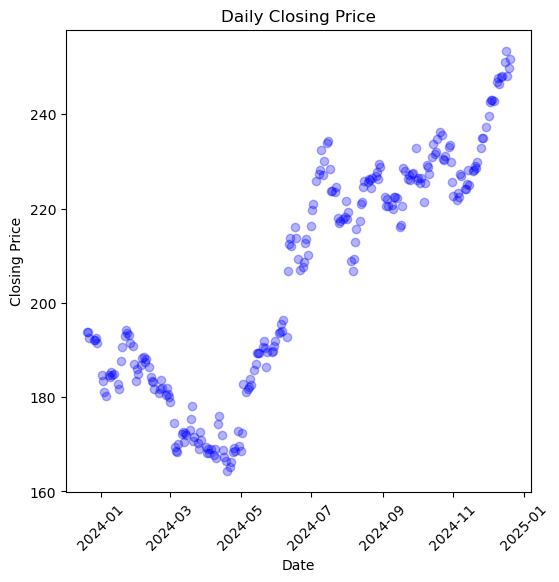

In [9]:
# Plot daily closing price
plt.figure(figsize=(6, 6))
plt.scatter(apple.index, apple['Close'], color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Daily Closing Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

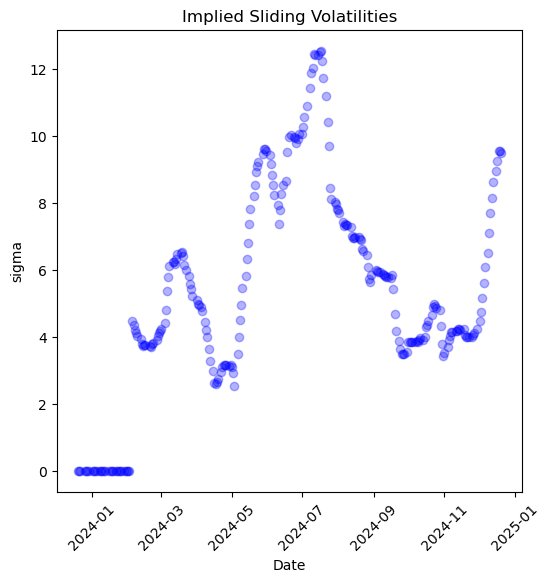

In [37]:
# Plot daily closing price
plt.figure(figsize=(6, 6))
plt.scatter(apple.index, sliding_sigmas, color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('sigma')
plt.title('Implied Sliding Volatilities')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

In [10]:
# Define the ticker symbol
ticker_symbol = "TSLA" # Tesla

# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)

# Fetch historical market data
historical_data = ticker.history(period="1y")  # data for the last year
tesla = pd.DataFrame(historical_data)

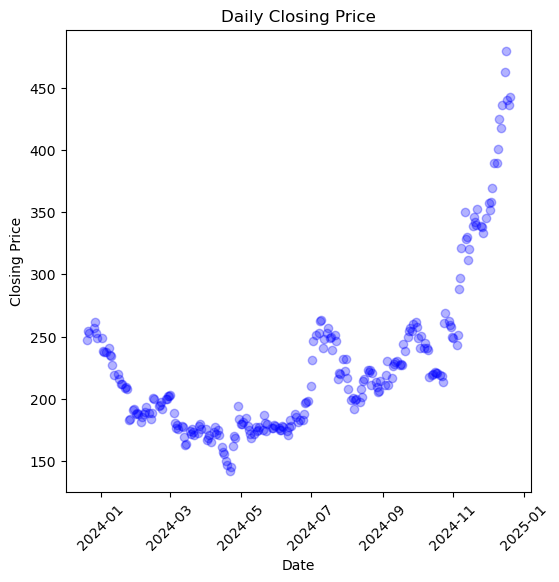

In [11]:
# Plot daily closing price
plt.figure(figsize=(6, 6))
plt.scatter(tesla.index, tesla['Close'], color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Daily Closing Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

In [12]:
volatilities(apple,'Close',5)

[22.855996257374063,
 30.682952390065513,
 223.9295749366656,
 29.869282218329612,
 67.51224330894175]

### Medium article

Below is some stuff from an [article](https://theaiquant.medium.com/mastering-option-pricing-with-machine-learning-a-practical-guide-to-valuing-real-options-data-1ef58c8d3a39).

In [13]:
# Define the ticker symbol for JPMorgan Chase & Co.
ticker_symbol = 'JPM'

# Initialize the yfinance Ticker object for JPM
jpm_ticker = yf.Ticker(ticker_symbol)

# Get available expiration dates
expiration_dates = jpm_ticker.options

# Choose an expiration date that exists in the list of available expiration dates
# For the purpose of this example, let's choose the first available expiration date
expiration_date = expiration_dates[0]

# Download the options data for JPM for the chosen expiration date
jpm_options = jpm_ticker.option_chain(expiration_date)

# Separate the calls and puts data
jpm_calls = jpm_options.calls
jpm_puts = jpm_options.puts

# Display the first few rows of the calls data
print(jpm_calls.head())

       contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0  JPM241220C00085000 2024-10-07 13:53:59+00:00    85.0     128.37  151.60   
1  JPM241220C00090000 2024-06-24 19:21:11+00:00    90.0     109.15  118.65   
2  JPM241220C00095000 2024-09-12 13:52:01+00:00    95.0     111.15  127.60   
3  JPM241220C00100000 2024-11-08 18:51:51+00:00   100.0     139.07  138.85   
4  JPM241220C00105000 2024-12-02 18:35:14+00:00   105.0     142.05  131.70   

     ask  change  percentChange  volume  openInterest  impliedVolatility  \
0  152.3     0.0            0.0     1.0             1           0.000010   
1  121.4     0.0            0.0     2.0             1           0.000010   
2  129.9     0.0            0.0     NaN             0           0.000010   
3  141.3     0.0            0.0     3.0             3          10.830081   
4  132.0     0.0            0.0     2.0             2           0.000010   

   inTheMoney contractSize currency  
0        True      REGULAR      USD 

In [14]:
expiration_dates

('2024-12-20',
 '2024-12-27',
 '2025-01-03',
 '2025-01-10',
 '2025-01-17',
 '2025-01-24',
 '2025-01-31',
 '2025-02-21',
 '2025-03-21',
 '2025-04-17',
 '2025-06-20',
 '2025-07-18',
 '2025-08-15',
 '2025-09-19',
 '2025-12-19',
 '2026-01-16',
 '2026-12-18',
 '2027-01-15')

In [15]:
# Preprocessing and feature engineering for JPM calls data
# Assume similar steps for puts data and other assets

# Drop rows with missing values
jpm_calls_cleaned = jpm_calls.dropna()

# Feature engineering: calculate moneyness, time to expiration and other relevant features
# Assuming that 'lastPrice' represents the current stock price
jpm_calls_cleaned['Moneyness'] = jpm_calls_cleaned['lastPrice'] / jpm_calls_cleaned['strike']
jpm_calls_cleaned['TimeToExpiration'] = (pd.to_datetime(expiration_date) - pd.Timestamp.now()).days

# Display the first few rows of the processed calls data
print(jpm_calls_cleaned.head())

       contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0  JPM241220C00085000 2024-10-07 13:53:59+00:00    85.0     128.37  151.60   
1  JPM241220C00090000 2024-06-24 19:21:11+00:00    90.0     109.15  118.65   
3  JPM241220C00100000 2024-11-08 18:51:51+00:00   100.0     139.07  138.85   
4  JPM241220C00105000 2024-12-02 18:35:14+00:00   105.0     142.05  131.70   
5  JPM241220C00110000 2024-11-20 15:38:13+00:00   110.0     130.34  126.70   

      ask  change  percentChange  volume  openInterest  impliedVolatility  \
0  152.30     0.0            0.0     1.0             1           0.000010   
1  121.40     0.0            0.0     2.0             1           0.000010   
3  141.30     0.0            0.0     3.0             3          10.830081   
4  132.00     0.0            0.0     2.0             2           0.000010   
5  126.95     0.0            0.0     1.0             8           0.000010   

   inTheMoney contractSize currency  Moneyness  TimeToExpiration  
0

/var/folders/4l/xdk1tfxx7jbd3zsydcl3t4vh0000gn/T/ipykernel_883/1641090000.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jpm_calls_cleaned['Moneyness'] = jpm_calls_cleaned['lastPrice'] / jpm_calls_cleaned['strike']
/var/folders/4l/xdk1tfxx7jbd3zsydcl3t4vh0000gn/T/ipykernel_883/1641090000.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jpm_calls_cleaned['TimeToExpiration'] = (pd.to_datetime(expiration_date) - pd.Timestamp.now()).days


Text(0, 0.5, 'Frequency')

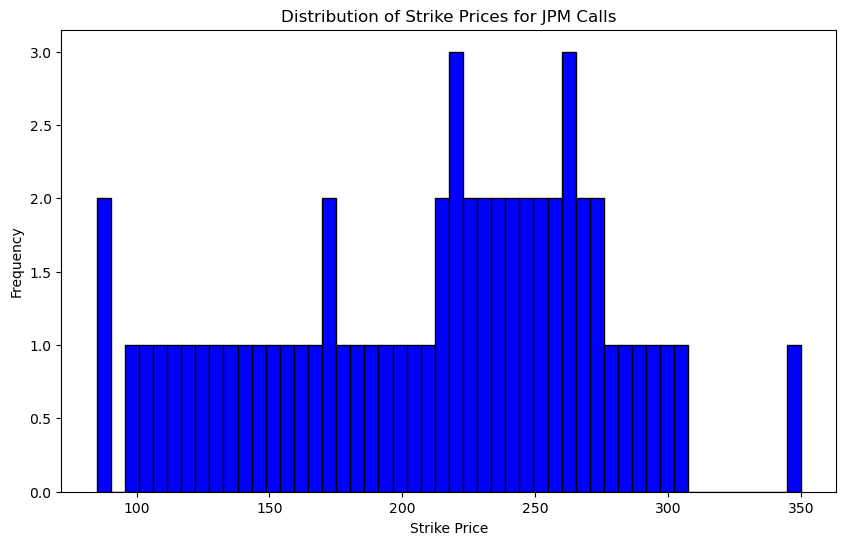

In [16]:
# Plot the distribution of strike prices for JPM calls
plt.figure(figsize=(10, 6))
plt.hist(jpm_calls_cleaned['strike'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Strike Prices for JPM Calls')
plt.xlabel('Strike Price')
plt.ylabel('Frequency')

In [17]:
jpm_calls_cleaned.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Moneyness,TimeToExpiration
0,JPM241220C00085000,2024-10-07 13:53:59+00:00,85.0,128.37,151.60,152.30,0.0,0.0,1.0,1,0.000010,True,REGULAR,USD,1.510235,-1
1,JPM241220C00090000,2024-06-24 19:21:11+00:00,90.0,109.15,118.65,121.40,0.0,0.0,2.0,1,0.000010,True,REGULAR,USD,1.212778,-1
3,JPM241220C00100000,2024-11-08 18:51:51+00:00,100.0,139.07,138.85,141.30,0.0,0.0,3.0,3,10.830081,True,REGULAR,USD,1.390700,-1
4,JPM241220C00105000,2024-12-02 18:35:14+00:00,105.0,142.05,131.70,132.00,0.0,0.0,2.0,2,0.000010,True,REGULAR,USD,1.352857,-1
5,JPM241220C00110000,2024-11-20 15:38:13+00:00,110.0,130.34,126.70,126.95,0.0,0.0,1.0,8,0.000010,True,REGULAR,USD,1.184909,-1


In [18]:
# Prepare the data for training the machine learning model
X = jpm_calls_cleaned[['Moneyness','TimeToExpiration', 'impliedVolatility']]
y = jpm_calls_cleaned['lastPrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=200,random_state=30)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Predict option prices on the test set
y_pred = rf_model.predict(X_test_scaled)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 32.08224060270796


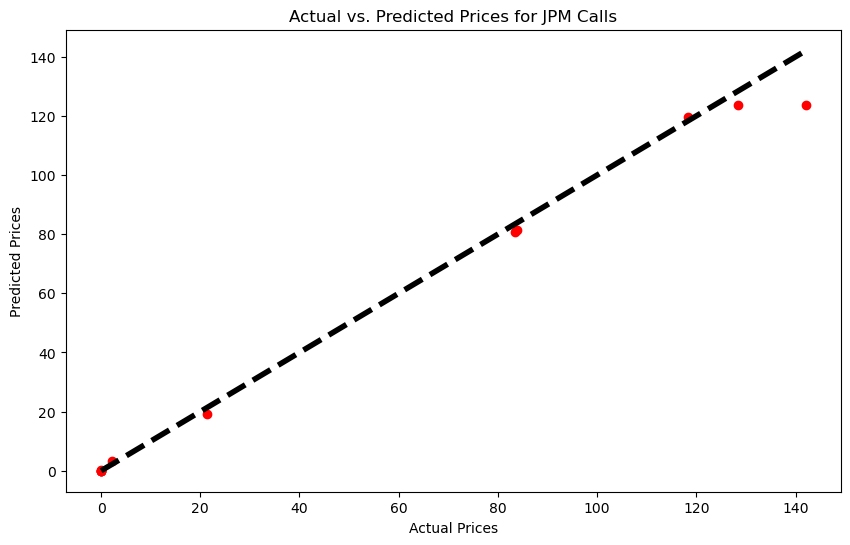

In [19]:
# Plot actual vs. predicted prices for JPM calls
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='red')
plt.title('Actual vs. Predicted Prices for JPM Calls')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)

Text(0, 0.5, 'Feature')

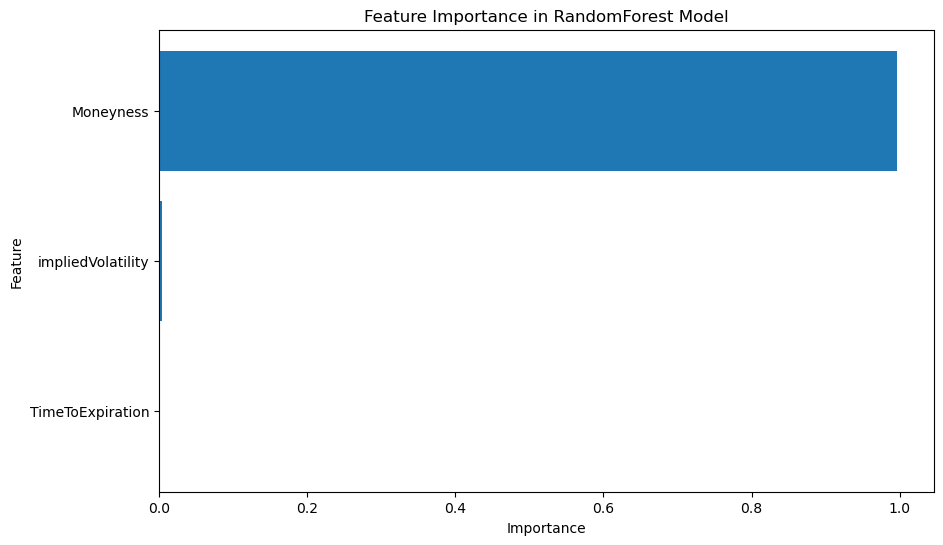

In [20]:
# Plot feature importance
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance in RandomForest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')